In [1]:
import os
import json
import sys
import warnings
import laspy
import open3d as o3d
sys.path.append("/data1/yang_liu/python_workspace/GSPL")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plyfile import PlyData, PlyElement

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def parse_ocam_model(xml_file, cam_idx=0):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    ocam_model = root.find(f".//CameraModel[SensorName='cam{cam_idx}']/OCamModel")
    c = float(ocam_model.find('c').text)
    d = float(ocam_model.find('d').text)
    e = float(ocam_model.find('e').text)
    cx = float(ocam_model.find('cx').text)
    cy = float(ocam_model.find('cy').text)
    world2cam = [float(coeff.text) for coeff in ocam_model.findall('world2cam/coeff')]
    cam2world = [float(coeff.text) for coeff in ocam_model.findall('cam2world/coeff')]

    return c, d, e, cx, cy, world2cam, cam2world

def project_points_to_image(points, c, d, e, cx, cy, world2cam):
    # Normalize the points
    norm = np.linalg.norm(points[:, :2], axis=1)[:, None]
    theta = np.arctan2(-points[:, [2]], norm)
    
    # Apply the world2cam polynomial
    rho = 0
    theta_i = 1
    for coeff in world2cam:
        rho += coeff * theta_i
        theta_i *= theta
    
    # Compute image coordinates
    x = points[:, [0]] * rho / norm
    y = points[:, [1]] * rho / norm
    x_img = x * c + y * d + cx
    y_img = x * e + y + cy
    
    return np.concatenate([x_img, y_img, rho], axis=1)


def read_las_fit(filename, attrs=None):
    """
    读取 las 文件，获取三维坐标 xyz, 颜色 rgb, 属性 attr_dict。当文件没有 RGB 信息时，返回全0的 RGB值
    Args:
        filename: <str> las 文件路径
        attrs: <list> 需要额外获取的属性信息 如 ['label']

    Returns:
        xyz, rgb, attr_dict
    """
    if attrs is None:
        attrs = []

    # 默认返回 scales, offsets ，合并 ["scales", "offsets"]
    attrs = list(set(attrs + ["scales", "offsets"]))

    # 读取点云
    inFile = laspy.read(filename)
    # inFile.point_format.dimensions可以获取所有的维度信息
    N_points = len(inFile)
    x = np.reshape(inFile.x, (N_points, 1))
    y = np.reshape(inFile.y, (N_points, 1))
    z = np.reshape(inFile.z, (N_points, 1))
    xyz = np.hstack((x, y, z))
    # TODO 注意。如果是大写的 X Y Z，需要转换后才是真实坐标: real_x = scale[0] * inFile.X + offset[0]

    # 初始化 rgb 全是 0
    rgb = np.zeros((N_points, 3), dtype=np.uint16)
    if hasattr(inFile, "red") and hasattr(inFile, "green") and hasattr(inFile, "blue"):
        r = np.reshape(inFile.red, (N_points, 1))
        g = np.reshape(inFile.green, (N_points, 1))
        b = np.reshape(inFile.blue, (N_points, 1))
        # i = np.reshape(inFile.Reflectance, (N_points, 1))
        rgb = np.float32(np.hstack((r, g, b))) / 65535
    else:
        print(f"注意：{filename.split('/')[-1]} 没有RGB信息，返回全0的RGB信息！")

    # 组织其他属性信息
    attr_dict = {}
    for attr in attrs:
        value = None
        # 先判断 是否为额外属性
        if hasattr(inFile, attr):
            value = getattr(inFile, attr)
        # 再判断 header 中是否有该属性
        elif hasattr(inFile.header, attr):
            value = getattr(inFile.header, attr)
        else:
            warnings.warn(f"{filename.split('/')[-1]} 没有属性= {attr} 的信息！", category=Warning)  # 使用 warnning 警告

        if hasattr(value, "array"):
            attr_dict[attr] = np.array(value)
        else:
            attr_dict[attr] = value

    return xyz, rgb, attr_dict

## 1. Read Point Cloud

In [3]:
dir_path = "../data/GKD/2024-08-13_05.18.43"

In [6]:
ground_dir_path = "../data/GKD/ground"
ground_pcd_path = os.path.join(ground_dir_path, 'pcd')
ground_pcd_list = sorted([os.path.join(ground_pcd_path, f) for f in os.listdir(ground_pcd_path) if f.endswith('.las')])
xyz_ground_list, rgb_ground_list = [], []
for ground_pcd_file in ground_pcd_list:
    xyz_ground, rgb_ground, _ = read_las_fit(ground_pcd_file, ["scales", "offsets"])
    xyz_ground_list.append(xyz_ground[::500])
    rgb_ground_list.append(rgb_ground[::500])

xyz_ground = np.concatenate(xyz_ground_list, axis=0)
rgb_ground = np.concatenate(rgb_ground_list, axis=0)

In [9]:
xyz_ground = np.concatenate(xyz_ground_list[:9], axis=0)
rgb_ground = np.concatenate(rgb_ground_list[:9], axis=0)

(472216.59640334937, 472491.74713603186, 4474804.891152116, 4474978.118166972)

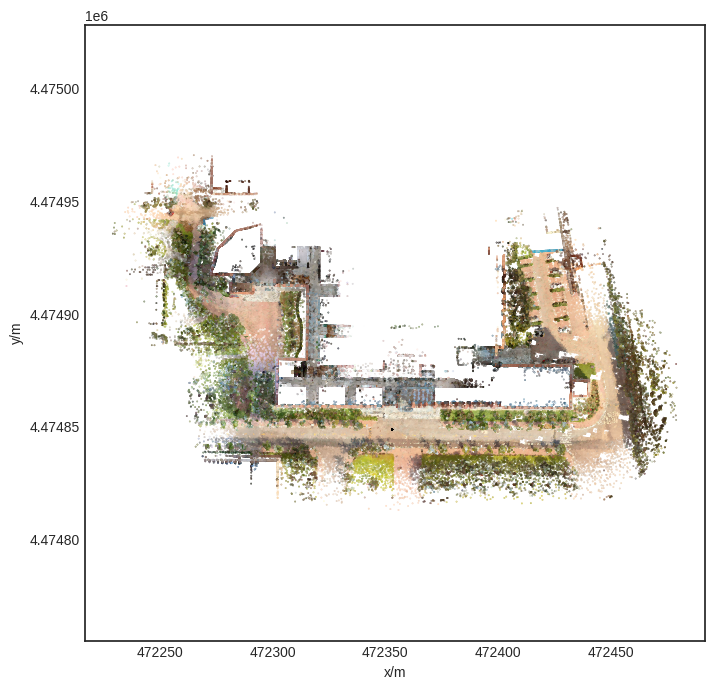

In [11]:
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(8, 8))
plt.scatter(xyz_ground[::5, 0], xyz_ground[::5, 1], c=rgb_ground[::5], s=0.1)
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.axis('equal')

In [3]:
aerial_dir_path = "../data/GKD/aerial_pcd"
aerial_pcd_list = sorted([os.path.join(aerial_dir_path, f) for f in os.listdir(aerial_dir_path) if f.endswith('.las')])
xyz_aerial_list, rgb_aerial_list = [], []
for aerial_pcd_file in aerial_pcd_list:
    xyz_aerial, rgb_aerial, _ = read_las_fit(aerial_pcd_file, ["scales", "offsets"])
    xyz_aerial_list.append(xyz_aerial[::500])
    rgb_aerial_list.append(rgb_aerial[::500])

xyz_aerial = np.concatenate(xyz_aerial_list, axis=0)
rgb_aerial = np.concatenate(rgb_aerial_list, axis=0)

(472240.0, 472460.0, 4474823.999999905, 4474956.000002002)

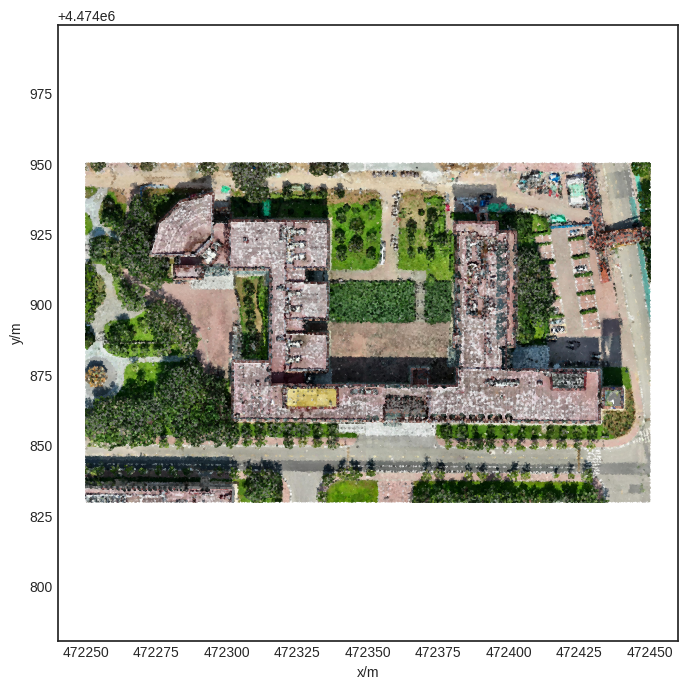

In [10]:
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(8, 8))
plt.scatter(xyz_aerial[:, 0], xyz_aerial[:, 1], c=rgb_aerial[:], s=0.1)
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.axis('equal')

(472240.0022, 472459.9978, 4474823.181131591, 4474958.985811591)

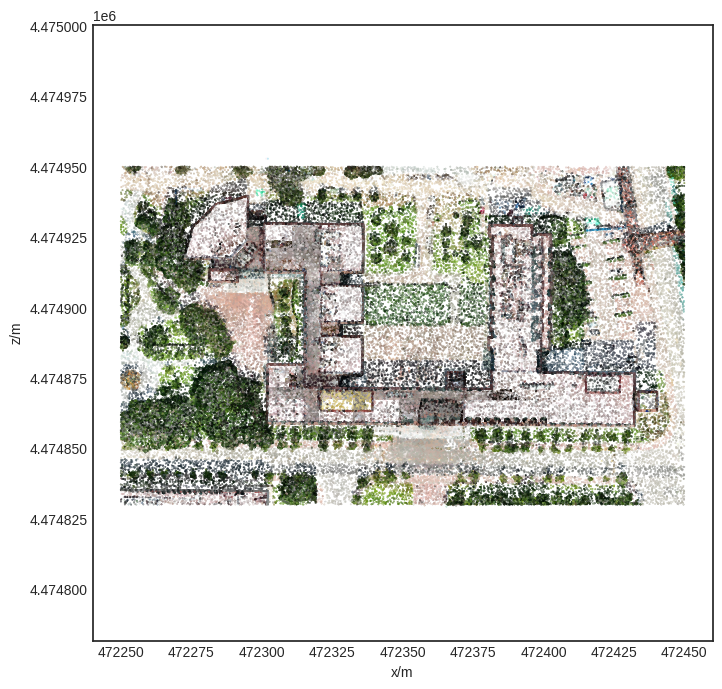

In [ ]:
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(8, 8))
plt.scatter(xyz_ground[::500, 0], xyz_ground[::500, 1], c=rgb_ground[::500], s=0.1)
plt.scatter(xyz_aerial[::10, 0], xyz_aerial[::10, 1], c=rgb_aerial[::10], s=0.1)
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.axis('equal')

## 2. Aligne Point Cloud

In [17]:
dir_path = "../data/GKD/2024-08-13_05.18.43"
pcd_path = os.path.join(dir_path, dir_path.split('/')[-1] + '.ply')
plydata = PlyData.read(pcd_path)
data = plydata.elements[0].data
property_names = data[0].dtype.names
data = pd.DataFrame(data)
data_np = np.zeros(data.shape, dtype=float)
for i, name in enumerate(property_names):
    data_np[:, i] = data[name]

In [43]:
pipreg = o3d.pipelines.registration

ds_interval = 500
src_pcd = data_np[::ds_interval, :3]
src_colors = data_np[::ds_interval, 3:6] / 255.0
tgt_pcd = xyz_ground[::ds_interval]
tgt_colors = rgb_ground[::ds_interval]

(472252.4987749646, 472407.23721380945, 4474822.95654197, 4474959.042291003)

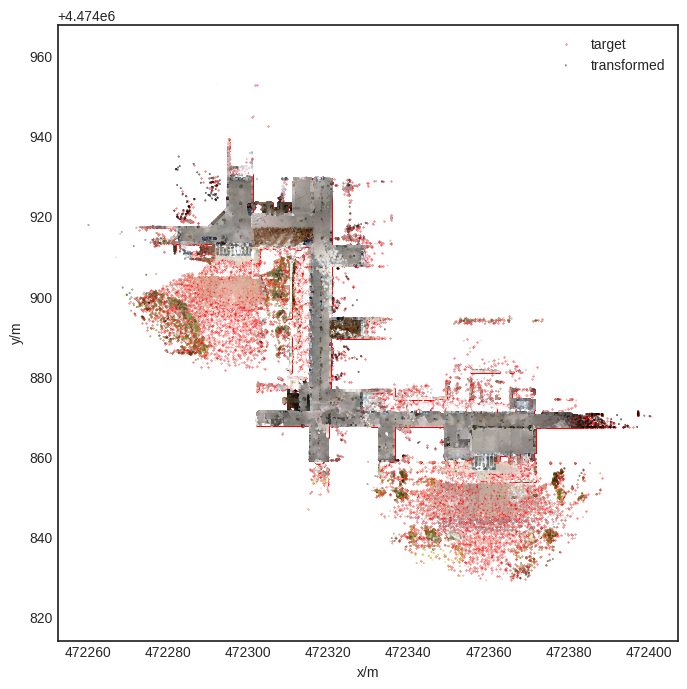

In [50]:
alignment = json.load(open(os.path.join(os.path.dirname(dir_path), 'align', dir_path.split('/')[-1], 'alignment.json')))

transform = np.array([
    [alignment['transform']['r11'], alignment['transform']['r12'], alignment['transform']['r13'], alignment['transform']['tx']],
    [alignment['transform']['r21'], alignment['transform']['r22'], alignment['transform']['r23'], alignment['transform']['ty']],
    [alignment['transform']['r31'], alignment['transform']['r32'], alignment['transform']['r33'], alignment['transform']['tz']]
])

transform_parent = np.array([
    [alignment['parent']['transform']['r11'], alignment['parent']['transform']['r12'], alignment['parent']['transform']['r13'], alignment['parent']['transform']['tx']],
    [alignment['parent']['transform']['r21'], alignment['parent']['transform']['r22'], alignment['parent']['transform']['r23'], alignment['parent']['transform']['ty']],
    [alignment['parent']['transform']['r31'], alignment['parent']['transform']['r32'], alignment['parent']['transform']['r33'], alignment['parent']['transform']['tz']]
])

src_pcd_homo = np.concatenate((src_pcd, np.ones_like(src_pcd[:, :1])), axis=-1)
dst_pcd = np.dot(src_pcd_homo, transform.T)
dst_pcd_homo = np.concatenate((dst_pcd, np.ones_like(dst_pcd[:, :1])), axis=-1)
dst_pcd = np.dot(dst_pcd_homo, transform_parent.T)

# visualize the init transformation
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(8, 8))
plt.scatter(tgt_pcd[:, 0], tgt_pcd[:, 1], c='r', s=0.1, label='target')
plt.scatter(dst_pcd[:, 0], dst_pcd[:, 1], c=src_colors, s=0.1, label='transformed')
plt.legend()
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.axis('equal')